In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("df_fusionne_clean.csv")
display(df.head())

# Après plusieurs messages d'erreurs dans la suite de ce notebook, il semble que la traduction avec Deepl ait échoué dans ~ 40 lignes sur les 83000+ que comporte le dataframe, résultant en la perte de ces 40 lignes transformées en NaN,
# La volumétrie étant faible, je me permets de les supprimer

df = df.dropna(subset=["merged"])


,productid,imageid,prdtypecode,merged,category_name
0,3804725264,1263597046,10,olivia carnet note personnaliser 150 page gril...,Livres occasion
1,436067568,1008141237,2280,journal art ndeg 133 28/09/2001 art marche sal...,Journaux et revues occasions
2,201115110,938777978,50,grand stylet ergonomique bleu gamepad nintendo...,Accessoires gaming
3,50418756,457047496,1280,peluche donald europe disneyland 2000 marionne...,Jouets enfant
4,278535884,1077757786,2705,guerre tuque luc idée grandeur vouloir organis...,Livres neufs


In [2]:
# Train_test_split

from sklearn.model_selection import train_test_split

X = df['merged']
y = df['prdtypecode']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=25)

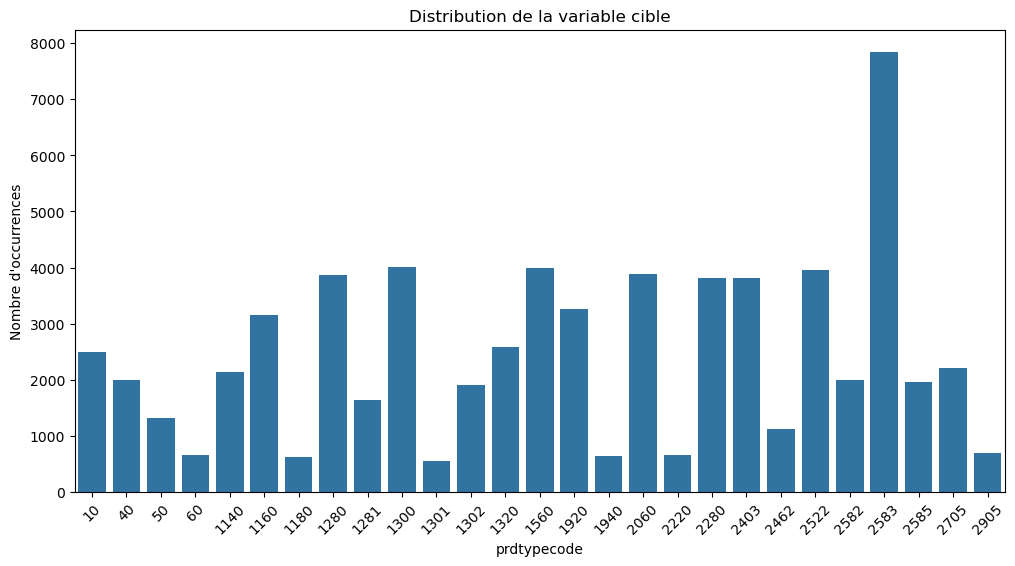

Minimum    Variable : 1301    Occurence : 554
Maximum    Variable : 2583    Occurence : 7850


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# REPARTITION DE LA VARIABLE CIBLE

# Occurrences de chaque catégorie
count_values = y_train.value_counts()

# Graphique 
plt.figure(figsize=(12,6))
sns.barplot(x=count_values.index, y=count_values.values)
plt.xlabel("prdtypecode")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution de la variable cible")
plt.xticks(rotation=45)
plt.show()

# Occurance min et max
print("Minimum    Variable :", count_values.idxmin(), "   Occurence :", count_values.min())
print("Maximum    Variable :", count_values.idxmax(), "   Occurence :", count_values.max())

Au vu de la distribution de la variable cible, nous choisissons d'équilibrer avec un nombre d'occurence cible de 4000

In [4]:
# VECTORISATION du texte avec Term Frequency - Inverse Document Frequency

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [6]:
# EQUILIBRAGE avec SMOTE et un nombre d'occurrences cible de 4000

from imblearn.over_sampling import SMOTE

# Préparation du rééchantillonnage selon la cible de 4000 occurences
target_count = 4000
current_counts = y_train.value_counts()
classes_to_oversample = current_counts[current_counts < target_count].index

# Dictionnaire pour sampling_strategy
sampling_strategy = {cls: target_count for cls in classes_to_oversample}

# Appliquation de SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=25)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)


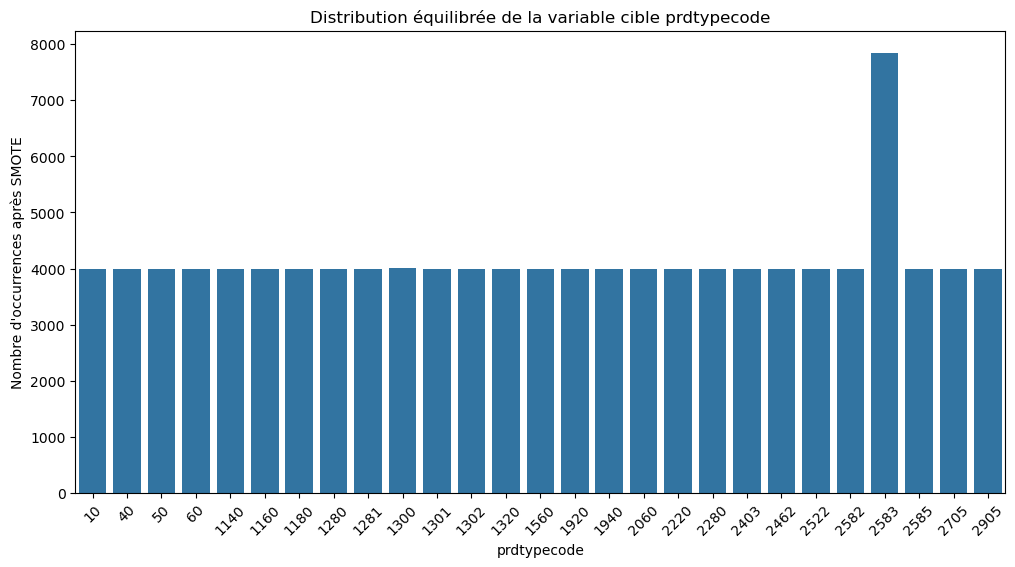

Minimum    Variable : 1560    Occurence : 4000
Maximum    Variable : 2583    Occurence : 7850


In [7]:
# REPARTITION DE LA VARIABLE CIBLE APRES EQUILIBRAGE AVEC SMOTE

y_train_res_series = pd.Series(y_train_res)
count_values_resampled = y_train_res_series.value_counts()

# Graphique
plt.figure(figsize=(12,6))
sns.barplot(x=count_values_resampled.index, y=count_values_resampled.values)
plt.xlabel("prdtypecode")
plt.ylabel("Nombre d'occurrences après SMOTE")
plt.title("Distribution équilibrée de la variable cible prdtypecode")
plt.xticks(rotation=45)
plt.show()

# Occurance min et max
print("Minimum    Variable :", count_values_resampled.idxmin(), "   Occurence :", count_values_resampled.min())
print("Maximum    Variable :", count_values_resampled.idxmax(), "   Occurence :", count_values_resampled.max())

Toutes les classes minoritaires ont maintenant bien 4000 occurences.
Nous allons maintenant réduire la classe majoritaire.

In [16]:
from imblearn.under_sampling import RandomUnderSampler

# Récupération des différentes classes présentes
unique_classes = np.unique(y_train_res)

# Construction du dictionnaire cible : chaque classe ramenée à 4000
undersample_strategy = {cls: 4000 for cls in unique_classes}

# Appliquation du RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=25)
X_train_final, y_train_final = under_sampler.fit_resample(X_train_res, y_train_res)

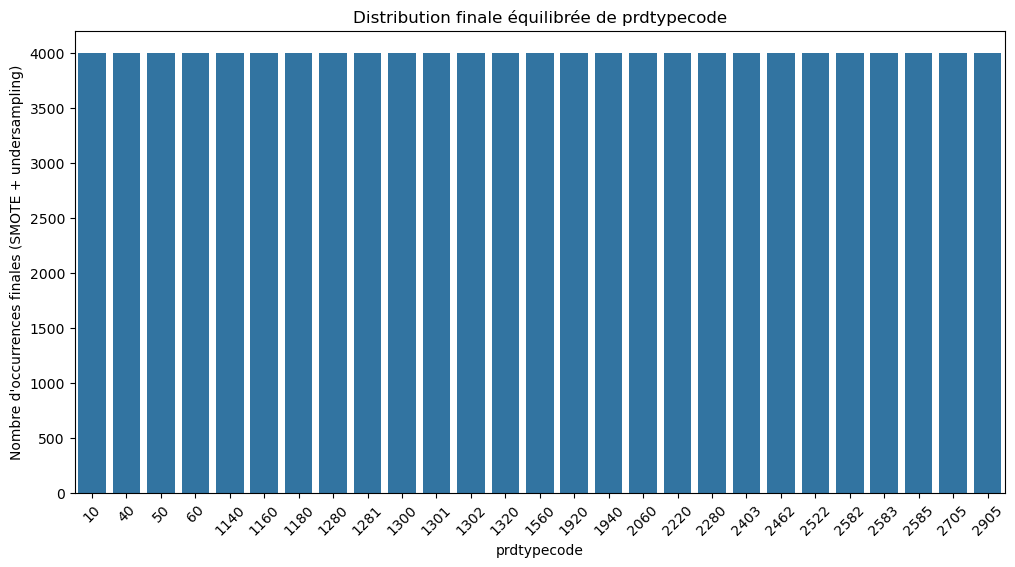

Minimum    Variable : 10    Occurrence : 4000
Maximum    Variable : 10    Occurrence : 4000


In [17]:
# REPARTITION DE LA VARIABLE CIBLE APRES SMOTE + UNDERSAMPLING
y_final_series = pd.Series(y_train_final)
count_values_final = y_final_series.value_counts()

# Graphique
plt.figure(figsize=(12,6))
sns.barplot(x=count_values_final.index, y=count_values_final.values)
plt.xlabel("prdtypecode")
plt.ylabel("Nombre d'occurrences finales (SMOTE + undersampling)")
plt.title("Distribution finale équilibrée de prdtypecode")
plt.xticks(rotation=45)
plt.show()

# Occurrence min et max
print("Minimum    Variable :", count_values_final.idxmin(), "   Occurrence :", count_values_final.min())
print("Maximum    Variable :", count_values_final.idxmax(), "   Occurrence :", count_values_final.max())

In [19]:
# SAUVEGARDE des données vectorisées et du vectorizer

import joblib

# Sauvegarde des données
joblib.dump(X_train_final, "X_train_final_tfidf.pkl")
joblib.dump(y_train_final, "y_train_final.pkl")
joblib.dump(X_test_vec, 'X_test_vec.pkl')
joblib.dump(y_test, 'y_test.pkl')

# Sauvegarde du vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']